In [6]:
import numpy as np
import matplotlib.pyplot as plt
import Crypto.Cipher.AES as AES
%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 10]

In [7]:
Sbox = (0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
        0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
        0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
        0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
        0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
        0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
        0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
        0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
        0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
        0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
        0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
        0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
        0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
        0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
        0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
        0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16)


hamming_weight = [bin(n).count("1") for n in range(0, 256)]

In [8]:
def cor(x, y):
    meanX = np.mean(x)
    meanY = np.mean(y)
    x = x - meanX
    y = y - meanY
    cov = sum(x*y)
    meanQuadraticX = sum(x ** 2)
    meanQuadraticY = sum(y ** 2)

    res = cov / np.sqrt(meanQuadraticX * meanQuadraticY)
    return abs(res)


def cross_all_bytes(texts_in, byte_num, n):
    for hyp in range(256):
        leak_array = np.zeros(n)
        for _i in range(n):
            # leak_array[_i] = hamming_weight(Sbox[texts_in[_i][byte_num]] ^ hyp)
            leak_array[_i] = hamming_weight[Sbox[texts_in[_i][byte_num] ^ hyp]]
        yield hyp, leak_array


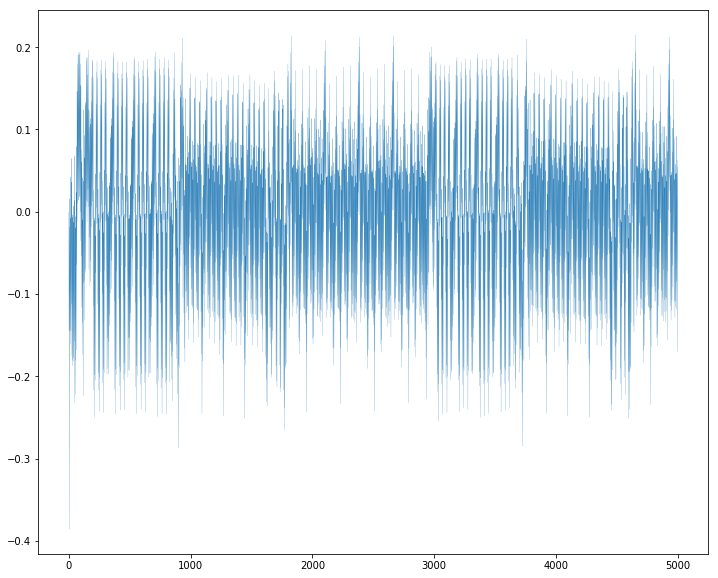

In [9]:
textIn = np.load('/files/univer/samsung/task1/textin.npy')
textOut = np.load('/files/univer/samsung/task1/textout.npy')
traces = np.load('/files/univer/samsung/task1/traces.npy')

traces_amount = len(traces)
meas_amount = len(traces[0])
tmp_traces = np.transpose(traces)

plt.plot(traces[0], linewidth=0.2)
plt.show()

In [10]:
key = []

leak_places = []
for k in range(16):
    max_cor = 0
    best_byte = 0
    leak_place = 0
    for byte, leak in cross_all_bytes(textIn, k, traces_amount):
        for i in range(meas_amount):
            real_values = tmp_traces[i]
            tmp_cor = cor(leak, real_values)
            # print(tmp_cor, cor2(leak, real_values))
            if tmp_cor > max_cor:
                max_cor = tmp_cor
                best_byte = byte
                leak_place = i
        # print(byte)

    leak_places.append(leak_place)
    key.append(best_byte)
    print('\nbyte number:', k)
    print('best byte:', best_byte)
    print('max correlation:', max_cor)
    print('leak place:', leak_places[-1])



byte number: 0
best byte: 78
max correlation: 0.8953794890873036
leak place: 954



byte number: 1
best byte: 48
max correlation: 0.8427208645460492
leak place: 1129



byte number: 2
best byte: 95
max correlation: 0.8946907405896911
leak place: 1306



byte number: 3
best byte: 71
max correlation: 0.8577883781361959
leak place: 1482



byte number: 4
best byte: 117
max correlation: 0.8863006067346022
leak place: 994



byte number: 5
best byte: 84
max correlation: 0.8739318435218355
leak place: 1686



byte number: 6
best byte: 53
max correlation: 0.908848473689249
leak place: 1346



byte number: 7
best byte: 95
max correlation: 0.8717569873660621
leak place: 1521



byte number: 8
best byte: 78
max correlation: 0.8634420818386443
leak place: 1033



byte number: 9
best byte: 111
max correlation: 0.8334658333639947
leak place: 1210



byte number: 10
best byte: 95
max correlation: 0.8997472281810905
leak place: 1386



byte number: 11
best byte: 83
max correlation: 0.8869495128518333
leak place: 1562



byte number: 12
best byte: 55
max correlation: 0.8721343341222365
leak place: 1074



byte number: 13
best byte: 48
max correlation: 0.8692334780420078
leak place: 1250



byte number: 14
best byte: 82
max correlation: 0.8269626619596463
leak place: 1426



byte number: 15
best byte: 89
max correlation: 0.8135430357290349
leak place: 1752


In [11]:
print('key: ', bytes(key))
print('leak places:', leak_places)


key:  b'N0_GuT5_No_S70RY'
leak places: [954, 1129, 1306, 1482, 994, 1686, 1346, 1521, 1033, 1210, 1386, 1562, 1074, 1250, 1426, 1752]


In [18]:
test_cipher = AES.new(bytes(key), AES.MODE_ECB)
print('plaintext:', textIn[0])
print('ciphertext in files:                ', bytes(list(textOut[0])))
print('ciphertext using found key:', test_cipher.encrypt(bytes(list(textIn[0]))))

plaintext: [156 135   7 127 141 111 213 234 169 189 200 111 126 215 234 164]
ciphertext in files:                 b'\xb3e<\x05i\xec\xb1\x8a\x83\xc8\x91\n\xcax%R'
ciphertext using found key: b'\xb3e<\x05i\xec\xb1\x8a\x83\xc8\x91\n\xcax%R'


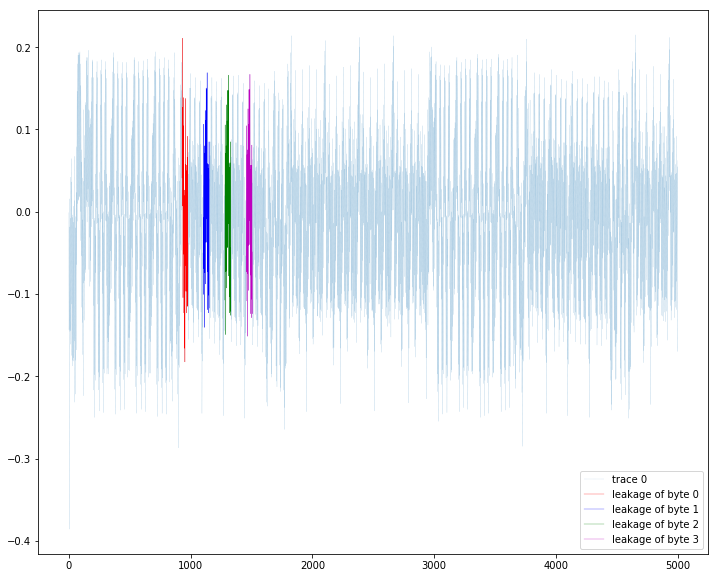

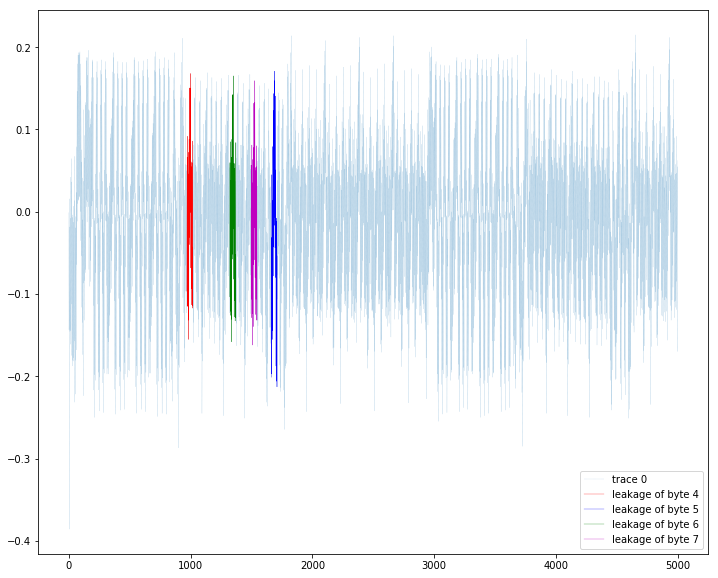

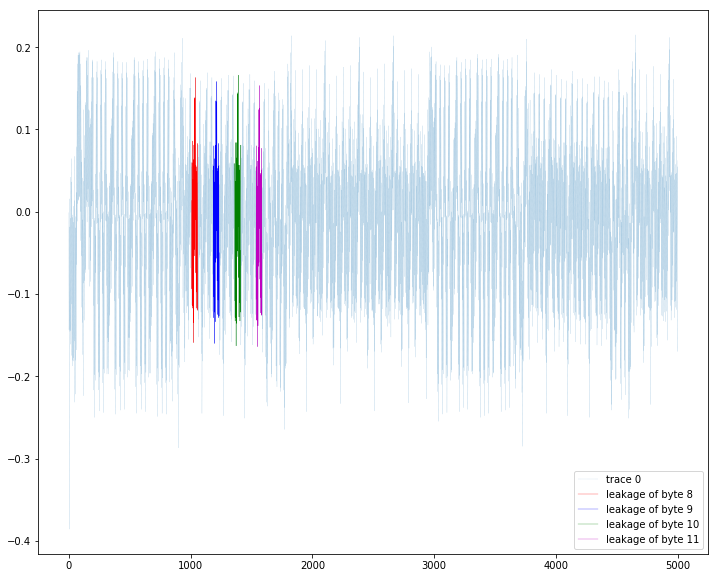

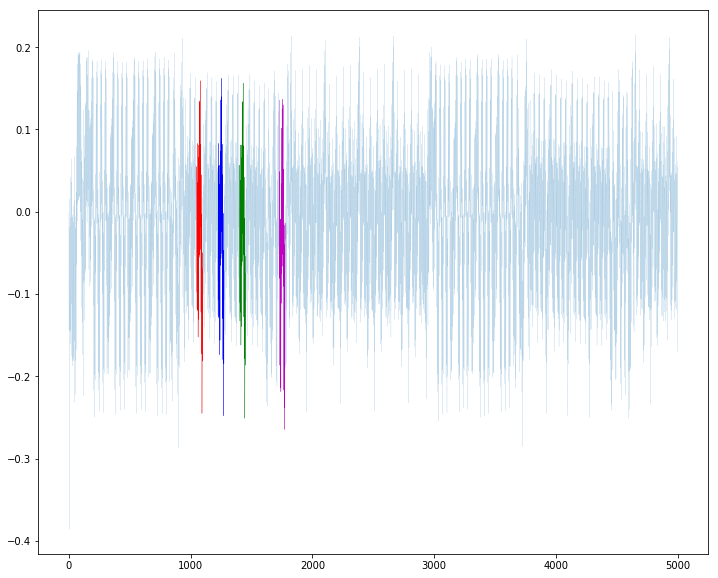

In [32]:
styles = ['r', 'b', 'g', 'm']
j = 0
plt.plot(np.array(range(5000)), traces[0], '--', linewidth=0.1, label='trace 0')
for i in range(16):
    if j == 4:
        plt.legend(loc='best')
        plt.show()
        plt.plot(np.array(range(5000)), traces[0], '--', linewidth=0.1, label='trace 0')
        j = 0
    plt.plot(np.array(range(leak_places[i]-25, leak_places[i]+25)), 
             traces[0, leak_places[i]-25:leak_places[i]+25], styles[j], 
             linewidth=0.3, label=f'leakage of byte {i}')
    j += 1
    